In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.python.saved_model import tag_constants
import skimage.transform
import glob
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
X_file = 'X_final.npy'
X = np.load(X_file)

In [3]:
m, n_H0, n_W0, n_C0 = X.shape

In [4]:
Y_file = 'Y_final.npy'
Y = np.load(Y_file)

In [5]:
train_index = np.load('train_index_final.npy')

In [6]:
dev_index = list(set(range(m)) - set(train_index))

In [7]:
m_train = train_index.shape[0]

In [8]:
X_train = X[train_index]
Y_train = Y[train_index]

X_dev = X[dev_index]
Y_dev = Y[dev_index]

In [9]:
def get_predictions(X, saved_model_loc, batch_size = 32):
    graph = tf.get_default_graph()
    with tf.Session(graph = graph) as sess:
        # Restore saved values
        
        tf.saved_model.loader.load(sess, [tag_constants.SERVING], saved_model_loc)
        
        # Get restored placeholders
        inputs = graph.get_tensor_by_name('inputs_ph:0')

        # Get restored model output
        predictions = graph.get_tensor_by_name('predictions:0')

        m = X.shape[0]
        num_batches = m//batch_size + 1

        Y_preds = np.empty(shape = m)
        
        for batch in range(num_batches):
                if batch != num_batches - 1:
                    batch_index = range(batch*batch_size, (batch+1)*batch_size)
                else:
                    batch_index = range(batch*batch_size,m)
                X_batch = X[batch_index]
                Y_batch_preds = sess.run(predictions, feed_dict ={inputs: X_batch})
                Y_preds[batch_index] = Y_batch_preds
    return Y_preds

In [10]:
saved_model_loc = 'resnet50-201811291327'
Y_train_preds = get_predictions(X_train, saved_model_loc)
Y_dev_preds = get_predictions(X_dev, saved_model_loc)

#Y_dev_preds_saved = get_predictions(X_dev, saved_model_loc)

INFO:tensorflow:Restoring parameters from resnet50-201811291327/variables/variables
INFO:tensorflow:Restoring parameters from resnet50-201811291327/variables/variables


In [11]:
Y_train_vec = np.argmax(Y_train, 1)
Y_dev_vec = np.argmax(Y_dev, 1)

In [12]:
def get_metrics(actuals, preds):
    accuracy = np.mean((actuals == preds).astype(int))
    cm = confusion_matrix(actuals, preds)
    diag = np.diagonal(cm)
    vert_sum = np.sum(cm, axis = 0)
    hor_sum = np.sum(cm, axis = 1)
    precision = np.nanmean(diag/vert_sum)
    recall = np.nanmean(diag/hor_sum)
    f1score = 2*precision*recall/(precision+recall)
    
    metrics = {'accuracy': accuracy,'confusion_matrix': cm, 'precision':precision, 'recall': recall, 'f1score': f1score}
    return metrics

In [13]:
train_metrics = get_metrics(Y_train_vec, Y_train_preds)
dev_metrics = get_metrics(Y_dev_vec, Y_dev_preds)

In [14]:
train_metrics

{'accuracy': 0.9718557607739666,
 'confusion_matrix': array([[ 1629,   302,     8,     7,    50,     1,     0],
        [    8, 12055,     4,     1,    13,     2,     2],
        [    2,     9,   898,     4,     6,     0,     0],
        [    0,    28,     5,  1141,     7,     0,     0],
        [    5,    73,     6,    10,  1873,     3,     0],
        [    0,     8,     0,     0,     0,  1025,     0],
        [    0,    12,     0,     0,     0,     0,  1269]]),
 'precision': 0.9808575670219725,
 'recall': 0.9557385640488185,
 'f1score': 0.968135160038415}

In [15]:
dev_metrics

{'accuracy': 0.8847845206684257,
 'confusion_matrix': array([[ 106,   83,    0,    8,   31,    0,    1],
        [  10, 1294,    6,    1,   13,    0,    1],
        [   1,    9,   85,    8,    3,    1,    2],
        [   1,    9,    5,   97,   15,    0,    0],
        [   5,   28,    0,    9,  185,    1,    0],
        [   0,    2,    0,    0,    0,  115,    0],
        [   0,    7,    2,    0,    0,    0,  130]]),
 'precision': 0.8747754026635844,
 'recall': 0.8160918858877658,
 'f1score': 0.8444153044081719}

In [16]:
Y_2_preds = get_predictions(np.expand_dims(X_train[2],0), saved_model_loc)

INFO:tensorflow:Restoring parameters from resnet50-201811261114/variables/variables


In [17]:
Y_2_preds

array([1.])

In [18]:
Y_train_preds[2]

0.0

In [158]:
def predict_one_img(img):
    graph = tf.get_default_graph()
    with tf.Session(graph = graph) as sess:
        # Restore saved values
        
        tf.saved_model.loader.load(sess, [tag_constants.SERVING], saved_model_loc)
        
        # Get restored placeholders
        inputs = graph.get_tensor_by_name('inputs_ph:0')
        Y_hat = graph.get_tensor_by_name('Y_hat:0')

        # Get restored model output
        predictions = graph.get_tensor_by_name('predictions:0')
        Y_hat_pred = sess.run(Y_hat, feed_dict ={inputs: img})
        pred = sess.run(predictions, feed_dict ={inputs: img})
    
    disease = class_labels[int(pred)]
    confidence = Y_hat_pred[0][int(pred)]
    
    return  confidence, disease   
        

In [139]:
def load_img_format(img_path):
    img = plt.imread(img_path)
    img = skimage.transform.resize(img, (224,224), mode='constant')
    img_arr = np.expand_dims(img, 0)
    return img_arr

In [7]:
def get_filelist(img_loc):
    filelist = glob.glob(img_loc+'*.jpg')
    filelist.sort()
    return filelist

In [39]:
class_labels = {0: 'Melanoma', 
                1: 'Melanocytic nevus', 
                2: 'Basal cell carcinoma', 
                3: 'Actinic keratosis', 
                4: 'Benign keratosis', 
                5: 'Dermatofibroma', 
                6: 'Vascular lesion'}
saved_model_loc = 'resnet50-201811220231'

In [142]:
def input_file_num(m):
    while 1:
        try:
            x = int(input('Enter a number between 1 and {} '.format(m)))
            if x > 1 and x < m:
                break
            else:
                print('This is not a valid input')
        except ValueError:
            print('This is not a valid input')
    return x

In [144]:
def plot_img(img):
    plt.title(filelist[x-1][-16:-4])
    plt.imshow(img[0])
    plt.axis('off')
    plt.show()

In [145]:
def predict_input(img_loc):
    filelist = get_filelist(img_loc)
    m = len(filelist)
    
    x = input_file_num(m)      
    img_path = filelist[x-1]
    img = load_img_format(img_path)
    
    plot_img(img)
    
    confidence, disease = predict_one_img(img)    
    print('Disease {} with a confidence of {:.2%}'.format(disease, confidence))
    

Enter a number between 1 and 10015 5


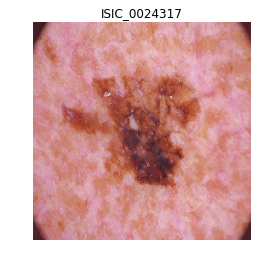

INFO:tensorflow:Restoring parameters from resnet50-201811220231/variables/variables
Disease Melanocytic nevus with a confidence of 99.16%


In [159]:
predict_input(img_loc)

In [148]:
disease = class_labels[int(pred)]

In [149]:
disease

'Melanocytic nevus'

In [154]:
confidence, disease = predict_one_img(img)

INFO:tensorflow:Restoring parameters from resnet50-201811220231/variables/variables


In [155]:
disease

array([1])

In [156]:
confidence

array([[8.4167011e-03, 9.9158329e-01, 4.8708623e-17, 5.9371147e-17,
        3.6283396e-12, 2.5445835e-18, 1.9108865e-14]], dtype=float32)